In [2]:
import pickle
import warnings
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import *
from gc import collect
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report


warnings.filterwarnings("ignore", message="X does not have valid feature names, but IncrementalPCA was fitted with feature names")
pd.options.mode.chained_assignment = None

In [3]:
full = pd.read_csv('data/training_set_VU_DM.csv', parse_dates=['date_time'])
enc = np.load('data/enc_train.npy')

full = full.drop(columns=['site_id', 'visitor_location_country_id', 'prop_country_id'])
full = clean(split_time(fillnans(full))).reset_index(drop=True)
full.head()

,srch_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,...,comp3_rate_missing,comp4_rate_missing,comp5_rate_missing,comp6_rate_missing,comp7_rate_missing,comp8_rate_missing,year,month,day,time
0,1,-1.0,-1.0,893,3,3.5,1,2.83,0.0438,4.95,...,0,1,0,1,1,0,13,4,4,0.355729
1,1,-1.0,-1.0,10404,4,4.0,1,2.20,0.0149,5.03,...,0,1,0,1,1,0,13,4,4,0.355729
2,1,-1.0,-1.0,21315,3,4.5,1,2.20,0.0245,4.92,...,0,1,0,1,1,0,13,4,4,0.355729
3,1,-1.0,-1.0,27348,2,4.0,1,2.83,0.0125,4.39,...,0,1,0,1,1,0,13,4,4,0.355729
4,1,-1.0,-1.0,29604,4,3.5,1,2.64,0.1241,4.93,...,0,1,0,1,1,0,13,4,4,0.355729


### Regression NN

In [4]:
net = nn.Sequential(
    nn.BatchNorm1d(220),
    nn.Linear(220, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 2048),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1)
).to('cuda')

optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=3e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

In [55]:
EPOCHS = 5

losses = list()
for i in range(EPOCHS):
    net.train
    data.shuffle()
    l = train(net, optimizer, criterion, data)
    losses.extend(l)
    print(sum(l)/len(l))

100%|██████████████████████████████████████████████████████████████████████████████| 4842/4842 [02:49<00:00, 28.65it/s]


tensor(0.6523)


100%|██████████████████████████████████████████████████████████████████████████████| 4842/4842 [02:58<00:00, 27.14it/s]


tensor(0.6337)


100%|██████████████████████████████████████████████████████████████████████████████| 4842/4842 [02:54<00:00, 27.71it/s]


tensor(0.6296)


100%|██████████████████████████████████████████████████████████████████████████████| 4842/4842 [03:14<00:00, 24.92it/s]


tensor(0.6276)


100%|██████████████████████████████████████████████████████████████████████████████| 4842/4842 [03:41<00:00, 21.88it/s]


tensor(0.6264)


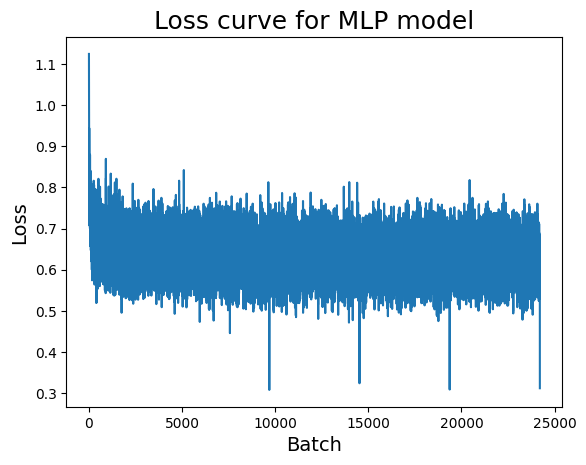

In [56]:
plot_loss(losses, 'MLP')
plt.show()

### Classification NN

In [37]:
net = nn.Sequential(
    nn.BatchNorm1d(220),
    nn.Linear(220, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 2048),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 3),
    nn.LogSoftmax(dim=1)
).to('cuda')

optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=3e-4, weight_decay=1e-4)
criterion = nn.NLLLoss(weight=torch.tensor([1, 5, 10], dtype=torch.float32, device='cuda'))

bs = 1024
data = DataLoader(full, bs)

In [55]:
EPOCHS = 5

losses = list()
for i in range(EPOCHS):
    net.train
    data.shuffle()
    l = train(net, optimizer, criterion, data, r=False)
    losses.extend(l)
    print(sum(l)/len(l))

100%|██████████████████████████████████████████████████████████████████████████████| 4842/4842 [02:49<00:00, 28.65it/s]


tensor(0.6523)


100%|██████████████████████████████████████████████████████████████████████████████| 4842/4842 [02:58<00:00, 27.14it/s]


tensor(0.6337)


100%|██████████████████████████████████████████████████████████████████████████████| 4842/4842 [02:54<00:00, 27.71it/s]


tensor(0.6296)


100%|██████████████████████████████████████████████████████████████████████████████| 4842/4842 [03:14<00:00, 24.92it/s]


tensor(0.6276)


100%|██████████████████████████████████████████████████████████████████████████████| 4842/4842 [03:41<00:00, 21.88it/s]


tensor(0.6264)


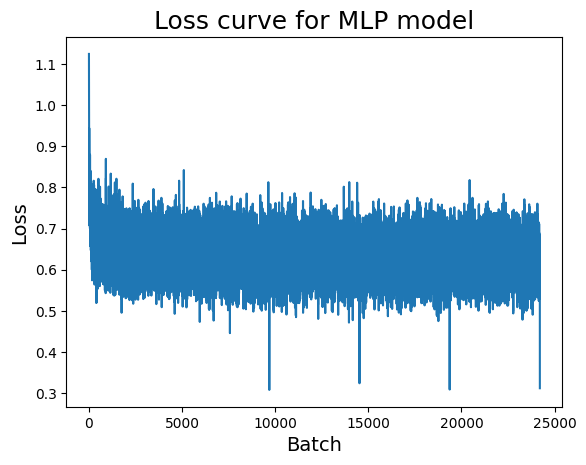

In [56]:
plot_loss(losses, 'MLP')
plt.show()

### Random forest

##### Hyperparameter tuning

In [ ]:
rf = RandomForestClassifier(class_weight={0: 1, 1: 15, 2: 30})
grid = dict(
    n_estimators=range(50, 151, 25),
    max_depth=range(3, 10, 2),
    ccp_alpha=[0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
)
rf = RandomizedSearchCV(rf, grid, cv=3, scoring='f1_macro', n_iter=6, n_jobs=4)
rf.fit(*pipeline(full.sample(frac=0.2), enc, regression=False, ret='numpy'))

In [7]:
rf.best_params_
# {'n_estimators': 50, 'max_depth': 3, 'ccp_alpha': 1e-05}

{'n_estimators': 50, 'max_depth': 3, 'ccp_alpha': 1e-05}

In [24]:
rf.cv_results_
# {'mean_fit_time': array([ 643.84064078, 1257.73229376,  429.61145679,  445.25928124,
#          813.26557541,  145.17661166]),
#  'std_fit_time': array([ 5.79680527,  7.20339834, 11.76421554, 87.28254363, 15.43636166,
#          9.42623269]),
#  'mean_score_time': array([ 7.7274785 , 12.36861753,  4.41931574,  2.08732255,  6.47897045,
#          2.4156599 ]),
#  'std_score_time': array([0.22518925, 0.91602329, 2.09578066, 1.47641725, 1.14712072,
#         0.31514727]),
#  'param_n_estimators': masked_array(data=[75, 150, 50, 100, 100, 50],
#               mask=[False, False, False, False, False, False],
#         fill_value='?',
#              dtype=object),
#  'param_max_depth': masked_array(data=[9, 9, 9, 5, 9, 3],
#               mask=[False, False, False, False, False, False],
#         fill_value='?',
#              dtype=object),
#  'param_ccp_alpha': masked_array(data=[0, 0, 0.001, 0.1, 1e-05, 1e-05],
#               mask=[False, False, False, False, False, False],
#         fill_value='?',
#              dtype=object),
#  'params': [{'n_estimators': 75, 'max_depth': 9, 'ccp_alpha': 0},
#   {'n_estimators': 150, 'max_depth': 9, 'ccp_alpha': 0},
#   {'n_estimators': 50, 'max_depth': 9, 'ccp_alpha': 0.001},
#   {'n_estimators': 100, 'max_depth': 5, 'ccp_alpha': 0.1},
#   {'n_estimators': 100, 'max_depth': 9, 'ccp_alpha': 1e-05},
#   {'n_estimators': 50, 'max_depth': 3, 'ccp_alpha': 1e-05}],
#  'split0_test_score': array([0.31429013, 0.31418736, 0.30414885, 0.32569374, 0.31449424,
#         0.33381632]),
#  'split1_test_score': array([0.31790068, 0.31860216, 0.30904478,        nan, 0.31706332,
#         0.33589133]),
#  'split2_test_score': array([0.31575002, 0.31738394, 0.31007619, 0.32569424, 0.31389261,
#         0.34977532]),
#  'mean_test_score': array([0.31598028, 0.31672449, 0.30775661,        nan, 0.31515006,
#         0.33982766]),
#  'std_test_score': array([0.00148297, 0.00186168, 0.00258559,        nan, 0.00137499,
#         0.00708488]),
#  'rank_test_score': array([3, 2, 5, 6, 4, 1])}

{'mean_fit_time': array([ 643.84064078, 1257.73229376,  429.61145679,  445.25928124,
         813.26557541,  145.17661166]),
 'std_fit_time': array([ 5.79680527,  7.20339834, 11.76421554, 87.28254363, 15.43636166,
         9.42623269]),
 'mean_score_time': array([ 7.7274785 , 12.36861753,  4.41931574,  2.08732255,  6.47897045,
         2.4156599 ]),
 'std_score_time': array([0.22518925, 0.91602329, 2.09578066, 1.47641725, 1.14712072,
        0.31514727]),
 'param_n_estimators': masked_array(data=[75, 150, 50, 100, 100, 50],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[9, 9, 9, 5, 9, 3],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_ccp_alpha': masked_array(data=[0, 0, 0.001, 0.1, 1e-05, 1e-05],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=obje

In [111]:
rf.best_params_
# {'n_estimators': 150, 'max_depth': 17, 'ccp_alpha': 0.01}

{'n_estimators': 150, 'max_depth': 17, 'ccp_alpha': 0.01}

In [121]:
rf.cv_results_
# {'mean_fit_time': array([ 532.65998745,  987.80120349,  261.76636759,  409.74045205,
#         1305.05142744,  522.79907115,  692.75769575,  568.40426135,
#          153.94705788,  601.19843348]),
#  'std_fit_time': array([55.37105425, 80.24138528, 13.39016069,  4.74820182, 51.6097449 ,
#         16.09744018,  7.51957552, 28.70440148,  2.72870464, 39.37195328]),
#  'mean_score_time': array([4.57506665, 9.97573566, 2.95933779, 3.00067385, 4.05100203,
#         1.457002  , 5.38554939, 2.47559627, 2.17474858, 1.85965697]),
#  'std_score_time': array([0.16864901, 0.45534029, 0.47085418, 0.08152517, 0.57337588,
#         0.04129388, 0.02984091, 0.11958048, 0.03572778, 0.04945915]),
#  'param_n_estimators': masked_array(data=[100, 150, 50, 50, 150, 75, 100, 100, 50, 100],
#               mask=[False, False, False, False, False, False, False, False,
#                     False, False],
#         fill_value='?',
#              dtype=object),
#  'param_max_depth': masked_array(data=[11, 14, 8, 14, 17, 17, 14, 11, 5, 14],
#               mask=[False, False, False, False, False, False, False, False,
#                     False, False],
#         fill_value='?',
#              dtype=object),
#  'param_ccp_alpha': masked_array(data=[0.0001, 0, 0.0001, 0.0001, 0.01, 0.1, 0.0001, 0.01,
#                     0.0001, 0.1],
#               mask=[False, False, False, False, False, False, False, False,
#                     False, False],
#         fill_value='?',
#              dtype=object),
#  'params': [{'n_estimators': 100, 'max_depth': 11, 'ccp_alpha': 0.0001},
#   {'n_estimators': 150, 'max_depth': 14, 'ccp_alpha': 0},
#   {'n_estimators': 50, 'max_depth': 8, 'ccp_alpha': 0.0001},
#   {'n_estimators': 50, 'max_depth': 14, 'ccp_alpha': 0.0001},
#   {'n_estimators': 150, 'max_depth': 17, 'ccp_alpha': 0.01},
#   {'n_estimators': 75, 'max_depth': 17, 'ccp_alpha': 0.1},
#   {'n_estimators': 100, 'max_depth': 14, 'ccp_alpha': 0.0001},
#   {'n_estimators': 100, 'max_depth': 11, 'ccp_alpha': 0.01},
#   {'n_estimators': 50, 'max_depth': 5, 'ccp_alpha': 0.0001},
#   {'n_estimators': 100, 'max_depth': 14, 'ccp_alpha': 0.1}],
#  'split0_test_score': array([0.80800654, 0.83818991, 0.85339809, 0.80375817, 0.95518034,
#         0.95518034, 0.80511075, 0.95518034, 0.93831094, 0.95518034]),
#  'split1_test_score': array([0.81193416, 0.83175079, 0.85437848, 0.80264464, 0.95518034,
#         0.95518034, 0.80154624, 0.95518034, 0.93635621, 0.95518034]),
#  'split2_test_score': array([0.83089697, 0.84456198, 0.85963405, 0.80920422, 0.95518323,
#         0.95518323, 0.80304649, 0.95518323, 0.93807473, 0.95518323]),
#  'mean_test_score': array([0.81694589, 0.83816756, 0.85580354, 0.80520234, 0.95518131,
#         0.95518131, 0.80323449, 0.95518131, 0.93758063, 0.95518131]),
#  'std_test_score': array([9.99436807e-03, 5.23017336e-03, 2.73799054e-03, 2.86603532e-03,
#         1.36249605e-06, 1.36249605e-06, 1.46126561e-03, 1.36249605e-06,
#         8.71148715e-04, 1.36249605e-06]),
#  'rank_test_score': array([ 8,  7,  6,  9,  1,  1, 10,  1,  5,  1])}

{'mean_fit_time': array([ 532.65998745,  987.80120349,  261.76636759,  409.74045205,
        1305.05142744,  522.79907115,  692.75769575,  568.40426135,
         153.94705788,  601.19843348]),
 'std_fit_time': array([55.37105425, 80.24138528, 13.39016069,  4.74820182, 51.6097449 ,
        16.09744018,  7.51957552, 28.70440148,  2.72870464, 39.37195328]),
 'mean_score_time': array([4.57506665, 9.97573566, 2.95933779, 3.00067385, 4.05100203,
        1.457002  , 5.38554939, 2.47559627, 2.17474858, 1.85965697]),
 'std_score_time': array([0.16864901, 0.45534029, 0.47085418, 0.08152517, 0.57337588,
        0.04129388, 0.02984091, 0.11958048, 0.03572778, 0.04945915]),
 'param_n_estimators': masked_array(data=[100, 150, 50, 50, 150, 75, 100, 100, 50, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[11, 14, 8, 14, 17, 17, 14, 11, 5, 14],


#### training

In [23]:
bp = {'n_estimators': 1, 'max_depth': 3, 'ccp_alpha': 1e-05}
bp = RandomForestClassifier(**bp, warm_start=True, class_weight={0: 1, 1: 30, 2: 45}, n_jobs=-1)
data = DataLoader(full, len(full) // 5 + 1)
for i in range(10):
    print(f"EPOCH {i}")
    data.shuffle()
    for x in data:
        bp.fit(*pipeline(x, enc, regression=False, ret='numpy'))
        bp.n_estimators += 1

EPOCH 0
EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9


In [24]:
x, y = pipeline(full.sample(frac=0.1), enc, regression=False, ret='numpy')
print(classification_report(y, bp.predict(x), zero_division=0))

              precision    recall  f1-score   support

           0       0.97      0.12      0.21    473657
           1       0.14      0.00      0.00      8253
           2       0.03      0.99      0.06     13810

    accuracy                           0.14    495720
   macro avg       0.38      0.37      0.09    495720
weighted avg       0.93      0.14      0.20    495720



## Super model

In [40]:
class Ranker(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(128, 32)
        self.lin2 = nn.Linear(128, 32)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.mlp_r = self.load_MLP('models/MLP_reg.pt')
        self.mlp_c = self.load_MLP('models/MLP_class.pt')
        self.rf_models = [pickle.load(open(f'models/rf_{m}.pkl', 'rb'))
                          for m in ['book', 'click', 'large', 'small']]
        self.seq1 = nn.Sequential(
            nn.BatchNorm1d(220),
            nn.Linear(220, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(512),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32)
        )
        self.seq2 = nn.Sequential(
            nn.Linear(216, 512),
            self.relu,
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            self.relu,
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            self.relu,
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    @staticmethod
    def load_MLP(path):
        model = torch.load(path)
        for i in ['19', '20', '21']:
            model.__setattr__(i, Identity())
        for p in model.parameters():
            p.requires_grad = False
        return model
    
    def forward(self, x):
        bs = len(x)
        x = x.reshape(2 * bs, -1)
        y = np.asarray([m.predict_proba(x) for m in self.rf_models])
        y = torch.tensor(y.reshape(bs, 2, -1), dtype=torch.float32, device='cuda')
        x = torch.tensor(x, dtype=torch.float32, device='cuda')
        x = torch.stack([self.lin1(self.mlp_c(x)), self.lin2(self.mlp_r(x)), self.seq1(x)], dim=1)
        x = self.relu(x).reshape(bs, 2, -1)
        x = torch.cat([self.flatten(x), self.flatten(y)], dim=1)
        return self.seq2(x)
    
    
r = Ranker().to('cuda')
criterion = nn.BCELoss()
optimizer = torch.optim.Adam([p for p in r.parameters() if p.requires_grad], lr=3e-4, weight_decay=1e-4)

In [34]:
data = DataLoader(pd.read_csv('data/targets.csv', index_col=False), 8192)

In [42]:
EPOCHS = 5

losses = list()
for e in range(EPOCHS):
    r.train()
    data.shuffle()
    l = list()
    for i, x in enumerate(tqdm(data)):
        y = torch.tensor(x.greater.to_numpy(), dtype=torch.float32, device='cuda')
        x = pipeline(full.loc[x[['first', 'second']].values.flatten()], enc, ret='numpy')[0].reshape(-1, 2, 220)
        optimizer.zero_grad()
        loss = criterion(r(x).flatten(), y)
        loss.backward()
        optimizer.step()
        l.append(loss.detach().cpu())
        # if i % 30 == 0:
        #     losses.extend(l)
        #     print(f"{sum(l)/len(l)}")
        #     l = list()
    losses.extend(l)
    print(f"Epoch {e}: {sum(l)/len(l)}")

100%|████████████████████████████████████████████████████████████████████████████| 8219/8219 [1:37:42<00:00,  1.40it/s]


Epoch 0: 0.5869097709655762


100%|████████████████████████████████████████████████████████████████████████████| 8219/8219 [1:37:36<00:00,  1.40it/s]


Epoch 1: 0.5736210942268372


100%|████████████████████████████████████████████████████████████████████████████| 8219/8219 [1:38:02<00:00,  1.40it/s]


Epoch 2: 0.5699625611305237


100%|████████████████████████████████████████████████████████████████████████████| 8219/8219 [1:38:05<00:00,  1.40it/s]


Epoch 3: 0.567974865436554


100%|████████████████████████████████████████████████████████████████████████████| 8219/8219 [1:40:30<00:00,  1.36it/s]

Epoch 4: 0.5667330622673035


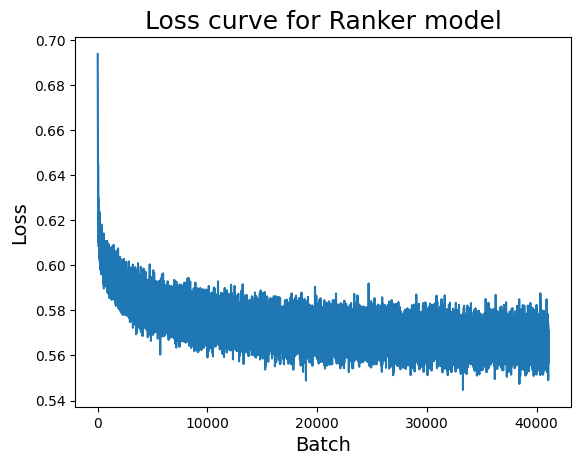

In [45]:
plot_loss(losses, 'Ranker', save='ranker')
plt.show()

In [44]:
torch.save(r, 'models/ranker3.pt')

### Other networks

In [24]:
class ResNet(nn.Module):
    def __init__(self, inp, hidden=1024):
        super().__init__()
        self.inp = inp
        self.hidden = hidden
        self.bn1 = nn.BatchNorm1d(inp)
        self.lin1 = nn.Linear(inp, hidden)
        self.lin2 = nn.Linear(2 * inp, hidden)
        self.lin3 = nn.Linear(2 * inp, hidden)
        self.lin4 = nn.Linear(2 * inp, hidden)
        self.lin5 = nn.Linear(inp, 1)
        self.relu = nn.ReLU()
        self.res1 = self.res_block()
        self.res2 = self.res_block()
        self.res3 = self.res_block()
        self.res4 = self.res_block()
    
    def res_block(self):
        return nn.Sequential(
            nn.BatchNorm1d(self.hidden),
            nn.Linear(self.hidden, 2 * self.hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2 * self.hidden, self.hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(self.hidden, self.hidden // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(self.hidden // 2, self.inp),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
    
    def forward(self, x):
        y = self.relu(self.lin1(self.bn1(x)))
        y = self.lin2(torch.hstack([self.res1(y), x]))
        y = self.lin3(torch.hstack([self.res2(y), x]))
        y = self.lin4(torch.hstack([self.res3(y), x]))
        y = self.lin5(self.res4(y))
        return nn.functional.sigmoid(y) * 5

In [25]:
net = ResNet(220).to('cuda')
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=3e-5, weight_decay=1e-4)

In [15]:
net = torch.load('ResNet.pt').to('cuda')
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=3e-5, weight_decay=1e-4)

In [26]:
EPOCHS = 5
bs = 1024

losses = list()
for i in range(EPOCHS):
    net.train
    l = train(net, optimizer, *pipeline(full.sample(frac=0.1)), bs=bs)
    losses.extend(l)
    print(sum(l)/len(l))

100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:32<00:00, 14.95it/s]


tensor(0.9175)


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:32<00:00, 14.89it/s]


tensor(0.7136)


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:33<00:00, 14.52it/s]


tensor(0.7182)


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:34<00:00, 13.90it/s]


tensor(0.7172)


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:35<00:00, 13.84it/s]

tensor(0.7139)


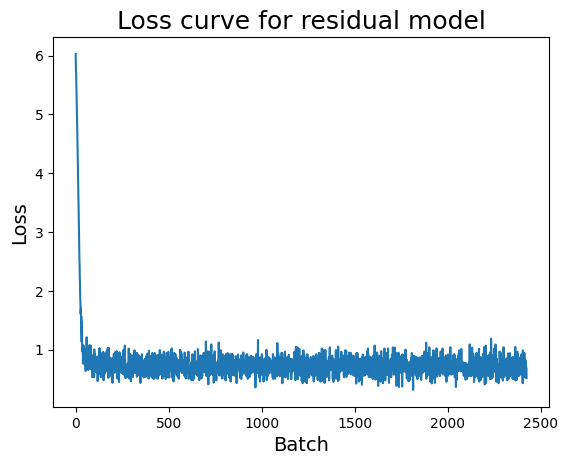

In [28]:
plot_loss(losses, 'residual')
plt.show()

In [28]:
torch.save(net, 'ResNet.pt')